In [103]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

In [104]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
print(indices)

['jobs_archive_2015-01-01 ', 'jobs_archive_2015-01-02 ', 'jobs_archive_2015-01-03 ', 'jobs_archive_2015-01-04 ', 'jobs_archive_2015-01-05 ', 'jobs_archive_2015-01-06 ', 'jobs_archive_2015-01-09 ', 'jobs_archive_2015-01-10 ', 'jobs_archive_2015-01-11 ', 'jobs_archive_2015-01-12 ', 'jobs_archive_2015-01-13 ', 'jobs_archive_2015-01-14 ', 'jobs_archive_2015-01-15 ', 'jobs_archive_2015-01-16 ', 'jobs_archive_2015-01-17 ', 'jobs_archive_2015-01-18 ', 'jobs_archive_2015-01-19 ', 'jobs_archive_2015-01-20 ', 'jobs_archive_2015-01-21 ', 'jobs_archive_2015-01-22 ', 'jobs_archive_2015-01-23 ', 'jobs_archive_2015-01-24 ', 'jobs_archive_2015-01-25 ', 'jobs_archive_2015-01-26 ', 'jobs_archive_2015-01-27 ', 'jobs_archive_2015-01-28 ', 'jobs_archive_2015-01-29 ', 'jobs_archive_2015-01-30 ', 'jobs_archive_2015-01-31 ', 'jobs_archive_2015-02-01 ', 'jobs_archive_2015-02-02 ', 'jobs_archive_2015-02-03 ', 'jobs_archive_2015-02-04 ', 'jobs_archive_2015-02-05 ', 'jobs_archive_2015-02-06 ', 'jobs_archive_2015-

In [105]:
def time_filter(indices, last_days=1, pattern=''):
    if last_days == 0:
        return ["jobs_archive_*"]
    filtered = []
    if pattern:
        for i in indices:
            if pattern in i:
                filtered.append(i.rstrip())
        return filtered
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

In [106]:
ind = time_filter(indices, 7, "2016-02" )
ind = ','.join(ind)
print(ind)

jobs_archive_2016-02-01,jobs_archive_2016-02-02,jobs_archive_2016-02-03,jobs_archive_2016-02-04,jobs_archive_2016-02-05,jobs_archive_2016-02-06,jobs_archive_2016-02-07,jobs_archive_2016-02-08,jobs_archive_2016-02-09,jobs_archive_2016-02-10,jobs_archive_2016-02-11,jobs_archive_2016-02-12,jobs_archive_2016-02-13,jobs_archive_2016-02-14,jobs_archive_2016-02-15,jobs_archive_2016-02-16,jobs_archive_2016-02-17,jobs_archive_2016-02-18,jobs_archive_2016-02-19,jobs_archive_2016-02-20,jobs_archive_2016-02-21,jobs_archive_2016-02-22,jobs_archive_2016-02-23,jobs_archive_2016-02-24,jobs_archive_2016-02-25,jobs_archive_2016-02-26,jobs_archive_2016-02-27,jobs_archive_2016-02-28,jobs_archive_2016-02-29


In [94]:
q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:reprocessing AND proddblock:*.00283429.*"
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:recon"

In [95]:
myquery = {
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "NOT produsername:gangarbt",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "match": {
                  "processingtype": {
                    "query": "reprocessing",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "match": {
                  "jobstatus": {
                    "query": "finished",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "query_string": {
                  "query": "proddblock:*.00282712.*",
                  "analyze_wildcard": True,
                  "lowercase_expanded_terms": False
                }
              }
            },
         ]
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "2": {
      "histogram": {
        "script": "(doc['nevents'].value) ? doc['wall_time'].value*10/doc['nevents'].value : 0",
        "lang": "expression",
        "interval": 5
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "atlasrelease",
            "size": 10
          }
        }
      }
    }
  }
}

In [96]:
res = es.search(index=ind, body=myquery, request_timeout=600)

In [97]:
print(res)

{'timed_out': False, '_shards': {'successful': 145, 'total': 145, 'failed': 0}, 'hits': {'total': 75200, 'max_score': 0.0, 'hits': []}, 'took': 28358, 'aggregations': {'2': {'buckets': [{'3': {'buckets': [{'score': 1.7227125297368677, 'key': 'Atlas-20.7.3', 'bg_count': 5802141, 'doc_count': 1976}], 'doc_count': 1976}, 'key': 0, 'doc_count': 1976}, {'3': {'buckets': [{'score': 1.6577952331594292, 'key': 'Atlas-20.7.3', 'bg_count': 5214565, 'doc_count': 776}], 'doc_count': 776}, 'key': 5, 'doc_count': 776}, {'3': {'buckets': [{'score': 1.445345654319648, 'key': 'Atlas-20.7.3', 'bg_count': 4110277, 'doc_count': 765}], 'doc_count': 765}, 'key': 10, 'doc_count': 765}, {'3': {'buckets': [{'score': 1.5218559926843118, 'key': 'Atlas-20.7.3', 'bg_count': 3744282, 'doc_count': 286}], 'doc_count': 286}, 'key': 15, 'doc_count': 286}, {'3': {'buckets': [{'score': 1.7989241481586207, 'key': 'Atlas-20.7.3', 'bg_count': 5318948, 'doc_count': 1583}], 'doc_count': 1583}, 'key': 20, 'doc_count': 1583}, {

101 1


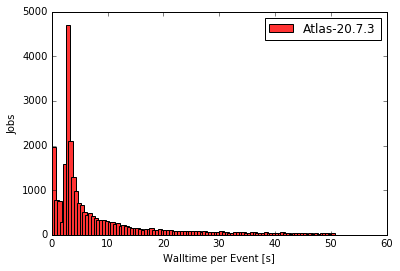

In [98]:
hists = []
xbins = []
rels = []

# First loop: determine AtlasRelease numbers and initialize histograms
for r in res['aggregations']['2']['buckets']:
    for e in r['3']['buckets']:
        if not e['key'] in rels:
            rels.append(e['key'])
            hists.append([])

# Now loop again and fill the histogram bins            
xbin = 0
for r in res['aggregations']['2']['buckets']:
    x = r['key']/10
    if x>50: # This is the x-axis cut !
        continue
    xbins.append(x)
    for hist in hists:
        hist.append(0)
    for e in r['3']['buckets']:
        #print(e)
        for rel, hist in zip(rels,hists):
            if e['key'] == rel:
                hist[xbin] = e['doc_count']
    xbin = xbin + 1

#print(hists)
print(len(xbins),len(hists))

# Initialisation for histogram stacking
y_offset = np.array([0.0] * len(xbins))
#colors = plt.cm.BuPu(np.linspace(0, 0.5, len(hists)))
allcolors = ('#ff3333', '#33ff33', '#3333ff', '#33ffff', "#ffffff", '#000000', '#ff0000', '#00ff00', '#0000ff')
colors = allcolors[:len(hists)]

for hist, rel, icolor in zip(hists,rels, colors):
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins, hist, bottom=y_offset, log=False, label=rel, color=icolor)
    y_offset = y_offset + hist
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    plt.xlabel('Walltime per Event [s]')
    plt.ylabel('Jobs')

plt.legend(loc='upper right')
plt.show()